In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import os, sys

In [2]:
sys.path.append("../")
import randman

In [3]:
seed = 13

In [4]:
def standardize(x, eps=1e-7):
    mi, _ = x.min(0)
    ma, _ = x.max(0)
    return (x - mi) / (ma - mi + eps)


def make_spiking_dataset(
    nb_classes=10,
    nb_units=100,
    nb_steps=100,
    step_frac=1.0,
    dim_manifold=2,
    nb_spikes=1,
    nb_samples=1000,
    alpha=2.0,
    shuffle=True,
    classification=True,
    seed=None,
):
    """Generates event-based generalized spiking randman classification/regression dataset.
    In this dataset each unit fires a fixed number of spikes. So ratebased or spike count based decoding won't work.
    All the information is stored in the relative timing between spikes.
    For regression datasets the intrinsic manifold coordinates are returned for each target.
    Args:
        nb_classes: The number of classes to generate
        nb_units: The number of units to assume
        nb_steps: The number of time steps to assume
        step_frac: Fraction of time steps from beginning of each to contain spikes (default 1.0)
        nb_spikes: The number of spikes per unit
        nb_samples: Number of samples from each manifold per class
        alpha: Randman smoothness parameter
        shuffe: Whether to shuffle the dataset
        classification: Whether to generate a classification (default) or regression dataset
        seed: The random seed (default: None)
    Returns:
        A tuple of data,labels. The data is structured as numpy array
        (sample x event x 2 ) where the last dimension contains
        the relative [0,1] (time,unit) coordinates and labels.
    """

    data = []
    labels = []
    targets = []

    if seed is not None:
        np.random.seed(seed)

    # max_value = np.iinfo(np.int).max
    max_value = 1e10
    randman_seeds = np.random.randint(max_value, size=(nb_classes, nb_spikes))

    for k in range(nb_classes):
        x = np.random.rand(nb_samples, dim_manifold)
        submans = [
            randman.Randman(nb_units, dim_manifold, alpha=alpha, seed=randman_seeds[k, i])
            for i in range(nb_spikes)
        ]
        units = []
        times = []
        for i, rm in enumerate(submans):
            y = rm.eval_manifold(x)
            y = standardize(y)
            units.append(np.repeat(np.arange(nb_units).reshape(1, -1), nb_samples, axis=0))
            times.append(y.numpy())

        units = np.concatenate(units, axis=1)
        times = np.concatenate(times, axis=1)
        events = np.stack([times, units], axis=2)
        data.append(events)
        labels.append(k * np.ones(len(units)))
        targets.append(x)

    data = np.concatenate(data, axis=0)
    labels = np.array(np.concatenate(labels, axis=0)).astype(int)
    targets = np.concatenate(targets, axis=0)

    if shuffle:
        idx = np.arange(len(data))
        np.random.shuffle(idx)
        data = data[idx]
        labels = labels[idx]
        targets = targets[idx]

    data[:, :, 0] *= nb_steps * step_frac
    # data = np.array(data, dtype=int)

    if classification:
        return data, labels
    else:
        return data, targets

In [5]:
# Create randman spiking dataset
data, labels = make_spiking_dataset(
    nb_classes=2, nb_units=30, nb_steps=100, dim_manifold=1, seed=42, nb_spikes=1, shuffle=True
)

In [7]:
data[..., 0]

array([[60.73658466, 39.91003036, 57.75480866, ..., 77.87185311,
        13.93392235, 68.43832731],
       [17.74590313, 18.85696799, 73.12753201, ..., 61.00797057,
        60.26594043, 63.09661269],
       [35.56572497, 66.82979465, 19.55391318, ..., 32.93485045,
         7.59997219, 17.89022535],
       ...,
       [75.46282411, 19.25308257, 38.06203306, ..., 70.61852813,
        95.655334  , 86.63207293],
       [87.19874024, 55.75323105, 25.49854219, ..., 97.13426828,
        61.82884574, 99.99991059],
       [38.57266009, 67.11211801, 38.37193251, ..., 56.54171109,
        44.74936128,  4.5346275 ]])

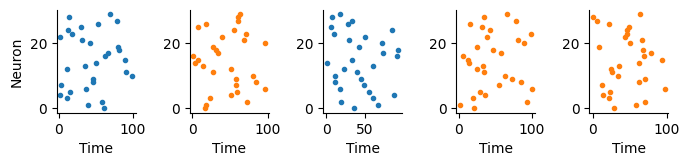

In [30]:
# Show spike raster plots four random example inputs

gs = GridSpec(1, 5)
fig = plt.figure(figsize=(7, 1.8), dpi=100)

for i in range(5):
    ax = fig.add_subplot(gs[i])
    ax.scatter(data[i, :, 0], data[i, :, 1], marker=".", color=sns.color_palette()[labels[i]])
    ax.set_xlabel("Time")
    if i == 0:
        ax.set_ylabel("Neuron")

plt.tight_layout()
sns.despine()